In [12]:
%matplotlib inline
import json

from os import path

import torch

from src import models
from src.utils import Args

from train_baseline import get_dataloaders as get_rgb_dataloaders

from torch.nn.functional import one_hot

from src.data.bridge_site import get_num_channels, get_dataloaders

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [4]:
rgb_path_transfer = "/data/b2p-siteident/experiments/new_baseline_rgb/r50_1200_v2_9_1"
with open(path.join(rgb_path_transfer, "opts.json")) as f:
    opts = json.load(f)

args = Args(**opts)
model = models.initialize_rgb_model(
    args.model_name, args.num_classes,
    use_last_n_layers=args.use_last_n_layers,
    use_pretrained=not args.no_use_pretrained)
best_fp = path.join(args.output_dir, "best.cpkt")
checkpoint = torch.load(best_fp)
model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

dataloaders = get_rgb_dataloaders(args)

all_labels = []
all_outputs = []
with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        oh_labels = one_hot(labels, 2)
        outputs = model(inputs)
        all_labels.append(oh_labels.cpu())
        all_outputs.append(outputs.cpu())
y_test = torch.cat(all_labels, 0).numpy()
y_score = torch.cat(all_outputs, 0).numpy()

# Compute ROC curve and ROC area for each class
n_classes = 2
fpr_rgb = dict()
tpr_rgb = dict()
roc_auc_rgb = dict()
for i in range(n_classes):
    fpr_rgb[i], tpr_rgb[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc_rgb[i] = auc(fpr_rgb[i], tpr_rgb[i])

# Compute micro-average ROC curve and ROC area
fpr_rgb["micro"], tpr_rgb["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc_rgb["micro"] = auc(fpr_rgb["micro"], tpr_rgb["micro"])

Loaded paths for train dataset (982 pos, 1024 neg, country: None)
Loaded paths for val dataset (261 pos, 261 neg, country: None)
Loaded paths for test dataset (434 pos, 434 neg, country: None)
Loaded paths for test dataset (370 pos, 370 neg, country: Rwanda)
Loaded paths for test dataset (64 pos, 64 neg, country: Uganda)


In [19]:
full_rn50_large = "/data/b2p-siteident/experiments/new_baseline_mods/r50_128_300_1200_v2_large_-1_0"

with open(path.join(full_rn50_large, "opts.json")) as f:
    opts = json.load(f)

args = Args(**opts)
args.no_use_several_test_samples = True

num_channels = get_num_channels(args.data_modalities)
model = models.initialize_mod_model(
    args.model, 2, num_channels, 
    use_last_n_layers=args.use_last_n_layers,
    use_pretrained=not args.no_use_pretrained)

best_model_fp = path.join(args.save_dir, "model_best.pt")
checkpoint = torch.load(best_model_fp, map_location="cpu")
state_dict = checkpoint['model_state_dict']

new_state_dict = {}
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

dataloaders = get_dataloaders(
    args.batch_size, args.tile_size,
    use_augment=not args.no_augmentation,
    use_several_test_samples=not args.no_use_several_test_samples,
    num_test_samples=args.num_test_samples,
    test_batch_size=56,
    data_version=args.data_version,
    data_order=args.data_modalities,
    ddp=False
)

all_labels = []
all_outputs = []

with torch.no_grad():
    for inputs, labels in dataloaders[2]:
        inputs = inputs.float().cuda()
        labels = labels.long().cuda()
        if not args.no_use_several_test_samples:
            batch_size, num_samples, c, w, h = inputs.shape
            inputs = inputs.view(batch_size * num_samples, c, w, h)
        else:
            batch_size = inputs.shape[0]
            num_samples = 1

        prediction = model(inputs)
        
        if not args.no_use_several_test_samples:
            labels_ = labels.unsqueeze(-1).repeat(
                1, num_samples).view(-1)
            prediction = torch.softmax(
                prediction.view(
                    batch_size, num_samples, -1), -1).mean(1)
        oh_labels = one_hot(labels, 2)
        all_labels.append(oh_labels.cpu())
        all_outputs.append(prediction.cpu())
        
y_test = torch.cat(all_labels, 0).numpy()
y_score = torch.cat(all_outputs, 0).numpy()

# Compute ROC curve and ROC area for each class
n_classes = 2
fpr_sup = dict()
tpr_sup = dict()
roc_auc_sup = dict()
for i in range(n_classes):
    fpr_sup[i], tpr_sup[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc_sup[i] = auc(fpr_sup[i], tpr_sup[i])

# Compute micro-average ROC curve and ROC area
fpr_sup["micro"], tpr_sup["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc_sup["micro"] = auc(fpr_sup["micro"], tpr_sup["micro"])

train sampler: 1964 samples in total (982 pos, 982 neg) ([Rwanda] 815 pos 654 neg [Uganda] 167 pos 328 neg)
val sampler: 522 samples in total (261 pos, 261 neg) ([Rwanda] 242 pos 130 neg [Uganda] 19 pos 131 neg)
test sampler: 868 samples in total (434 pos, 434 neg) ([Rwanda] 370 pos 217 neg [Uganda] 64 pos 217 neg)
test sampler: 740 samples in total (370 pos, 370 neg) ([Rwanda] 370 pos 370 neg [Uganda] 0 pos 0 neg)
test sampler: 128 samples in total (64 pos, 64 neg) ([Rwanda] 0 pos 0 neg [Uganda] 64 pos 64 neg)


In [7]:
ssl_path = ("/data/b2p-siteident/experiments/ssl_results/"
            "data-v2/resnet50_ema-0.75_lmdu-0.01_T-0.5_a-0.25_tile-1200_freeze--1/v0")

with open(path.join(ssl_path, "opts.json")) as f:
    opts = json.load(f)

args = Args(**opts)
args.use_several_test_samples = True

model_fp = path.join(args.out, "model_best.pth.tar")
checkpoint = torch.load(model_fp, map_location="cpu")

num_channels = get_num_channels(args.data_modalities)
ema_model = models.initialize_mod_model(
    args.model, 2, num_channels, use_last_n_layers=args.use_last_n_layers,
    use_pretrained=not args.no_use_pretrained)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ema_model = model.to(device)
ema_model.eval()

dataloaders = get_dataloaders(
    args.batch_size, args.tile_size,
    use_augment=not args.no_augmentation,
    use_several_test_samples=args.use_several_test_samples,
    num_test_samples=args.num_test_samples,
    test_batch_size=args.test_batch_size,
    data_version=args.data_version,
    data_order=args.data_modalities
)

with torch.no_grad():
    for inputs, targets in dataloaders[2]:
        inputs = inputs.float().cuda()
        labels = labels.long().cuda()
        
        # measure data loading time
        inputs = inputs.float()
        batch_size = inputs.shape[0]
        inputs, targets = inputs.cuda(), targets.cuda()
        if args.use_several_test_samples:
            batch_size, num_samples, c, w, h = inputs.shape
            inputs_ = inputs.view(batch_size * num_samples, c, w, h)
            targets_ = targets.view(-1, 1).repeat(1, num_samples).view(
                batch_size * num_samples)
        else:
            inputs_ = inputs
            targets_ = targets
        oh_targets_ = one_hot(targets, 2)
        # compute output
        outputs = ema_model(inputs_)
        # measure accuracy and record loss
        if args.use_several_test_samples:
            outputs = torch.softmax(
                outputs.view(batch_size, num_samples, -1), -1).mean(1)
    y_test = torch.cat(all_labels, 0).numpy()
    y_score = torch.cat(all_outputs, 0).numpy()

# Compute ROC curve and ROC area for each class
n_classes = 2
fpr_ssl = dict()
tpr_ssl = dict()
roc_auc_ssl = dict()
for i in range(n_classes):
    fpr_ssl[i], tpr_ssl[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc_ssl[i] = auc(fpr_ssl[i], tpr_ssl[i])

# Compute micro-average ROC curve and ROC area
fpr_ssl["micro"], tpr_ssl["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc_ssl["micro"] = auc(fpr_ssl["micro"], tpr_ssl["micro"])

train sampler: 1964 samples in total (982 pos, 982 neg) ([Rwanda] 815 pos 654 neg [Uganda] 167 pos 328 neg)
val sampler: 522 samples in total (261 pos, 261 neg) ([Rwanda] 242 pos 130 neg [Uganda] 19 pos 131 neg)
test sampler: 868 samples in total (434 pos, 434 neg) ([Rwanda] 370 pos 217 neg [Uganda] 64 pos 217 neg)
test sampler: 740 samples in total (370 pos, 370 neg) ([Rwanda] 370 pos 370 neg [Uganda] 0 pos 0 neg)
test sampler: 128 samples in total (64 pos, 64 neg) ([Rwanda] 0 pos 0 neg [Uganda] 64 pos 64 neg)


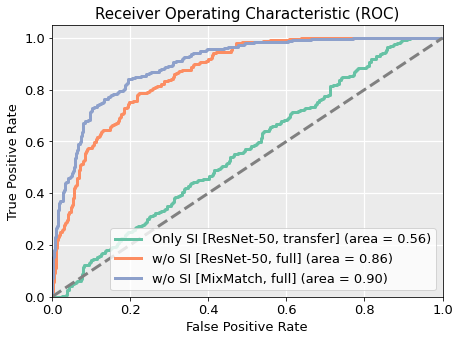

In [39]:
plt.figure(figsize=(7, 5))
lw = 3
ax=plt.axes()
ax.set_facecolor('#EBEBEB')
ax.grid(which='major', color='white', linewidth=1.2)
ax.grid(which='minor', color='white', linewidth=0.6)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.plot(
    fpr_rgb[1],
    tpr_rgb[1],
    color="#66c2a5",
    lw=lw,
    label="Only SI [ResNet-50, transfer] (area = %0.2f)" % roc_auc_rgb[1],
)

plt.plot(
    fpr_sup[1],
    tpr_sup[1],
    color="#fc8d62",
    lw=lw,
    label="w/o SI [ResNet-50, full] (area = %0.2f)" % roc_auc_sup[1],
)

plt.plot(
    fpr_ssl[1],
    tpr_ssl[1],
    color="#8da0cb",
    lw=lw,
    label="w/o SI [MixMatch, full] (area = %0.2f)" % roc_auc_ssl[1],
)

plt.plot([0, 1], [0, 1], color="grey", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.title("Receiver Operating Characteristic (ROC)", fontsize=15)
plt.legend(loc="lower right", fontsize=13)
plt.savefig("roc.pdf", dpi=300)
plt.show()

In [16]:
tpr_ssl[1]

array([0.        , 0.00230415, 0.07142857, 0.07142857, 0.15207373,
       0.15207373, 0.18202765, 0.18202765, 0.23041475, 0.23041475,
       0.24423963, 0.24423963, 0.26728111, 0.26728111, 0.2718894 ,
       0.2718894 , 0.33410138, 0.33410138, 0.3640553 , 0.3640553 ,
       0.37096774, 0.37096774, 0.40552995, 0.40552995, 0.4124424 ,
       0.4124424 , 0.41705069, 0.41705069, 0.44009217, 0.44009217,
       0.44239631, 0.44239631, 0.44470046, 0.44470046, 0.45852535,
       0.45852535, 0.46313364, 0.46313364, 0.46774194, 0.46774194,
       0.47926267, 0.47926267, 0.48617512, 0.48617512, 0.49539171,
       0.49539171, 0.5       , 0.5       , 0.53686636, 0.53686636,
       0.55529954, 0.55529954, 0.56682028, 0.56682028, 0.5921659 ,
       0.5921659 , 0.59907834, 0.59907834, 0.61981567, 0.61981567,
       0.63824885, 0.63824885, 0.66589862, 0.66589862, 0.67281106,
       0.67281106, 0.6797235 , 0.6797235 , 0.68202765, 0.68202765,
       0.71428571, 0.71428571, 0.71658986, 0.71658986, 0.73041

In [17]:
tpr_sup[1]

array([0.        , 0.00230415, 0.07834101, 0.07834101, 0.16129032,
       0.16129032, 0.16359447, 0.16359447, 0.25345622, 0.25345622,
       0.28341014, 0.28341014, 0.31797235, 0.31797235, 0.32488479,
       0.32488479, 0.32718894, 0.32718894, 0.35714286, 0.35714286,
       0.36635945, 0.36635945, 0.38018433, 0.38018433, 0.43548387,
       0.43548387, 0.46543779, 0.46543779, 0.47004608, 0.47004608,
       0.47695853, 0.47695853, 0.48156682, 0.48156682, 0.48387097,
       0.48387097, 0.49078341, 0.49078341, 0.49308756, 0.49308756,
       0.49769585, 0.49769585, 0.51843318, 0.51843318, 0.53917051,
       0.53917051, 0.57373272, 0.57373272, 0.58294931, 0.58294931,
       0.58525346, 0.58525346, 0.5921659 , 0.5921659 , 0.62903226,
       0.62903226, 0.6359447 , 0.6359447 , 0.64285714, 0.64285714,
       0.64516129, 0.64516129, 0.65207373, 0.65207373, 0.65437788,
       0.65437788, 0.65668203, 0.65668203, 0.65898618, 0.65898618,
       0.66129032, 0.66129032, 0.66589862, 0.66589862, 0.66820